In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from mnist import MNIST

In [2]:
data = MNIST(data_dir="data/MNIST/")

In [3]:
# 查看数据集的大小
print("训练集的大小：", data.num_train)
print("验证集的大小:", data.num_val)
print("测试集的大小:", data.num_test)

训练集的大小： 55000
验证集的大小: 5000
测试集的大小: 10000


In [4]:
# 复制数据维度信息

# 图片展开的大小
img_size_flat = data.img_size_flat

#图片原始尺寸
img_shape = data.img_shape

# 类别数
num_classes = data.num_classes

In [5]:
# 打印前5个测试集的label信息
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

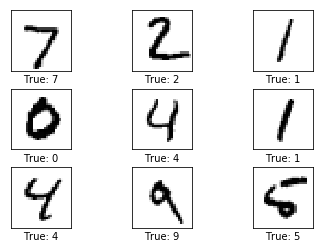

In [7]:
# 查看9张测试集的图片和对应的label
images = data.x_test[0:9]
cls_true = data.y_test_cls[0:9]
plot_images(images, cls_true=cls_true)

### Step 1：初始化模型的变量占位符：placeholder

In [8]:
# 输入图像的placeholder
x = tf.placeholder(dtype=tf.float32, shape=(None, img_size_flat), name="x")

In [9]:
# 输入图像的label向量，长度是num_classes 的placeholder
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name="y_true")

In [10]:
# 输入图像的label类别编号 整形变量
y_true_cls = tf.placeholder(dtype=tf.int64, shape=[None])

In [11]:
# 初始化权重矩阵
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [12]:
# 初始化bias变量
biases = tf.Variable(tf.zeros([num_classes]))

### Step2：建立模型

In [13]:
# 建立模型
logits = tf.matmul(x, weights) + biases

In [14]:
# 将logits的预测向量 进行softmax激活变换 归一化到0-1之间 并 使之和为1
y_pred = tf.nn.softmax(logits)

In [15]:
# 将y_pred中取每行最大元素的索引值来得到预测的类别
y_pred_cls = tf.argmax(y_pred, axis=1)

### Step3：优化损失函数

In [16]:
# 利用损失函数优化模型，改变weights和bias，使得y_pred输出接近真实值y_true
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)

In [17]:
# 求出所有图像预测的交叉熵以均值作为优化的目标
cost = tf.reduce_mean(cross_entropy)

In [18]:
# 为优化指标建立优化器进行优化
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

### Step4:性能评估

In [19]:
# 建立性能度量来评估分类的准确性 这里我们用accuracy来评估
corr_pred = tf.equal(y_true_cls, y_pred_cls)
# 利用cast函数对bool值变量进行转换，转换为浮点值，并求出 准确率
accuracy = tf.reduce_mean(tf.cast(corr_pred, tf.float32))

### Step5:利用会话运行计算图

In [20]:
# 创建Tensorflow 会话来运行计算图
session = tf.Session()

In [21]:
# 初始化tensorflow的变量
session.run(tf.global_variables_initializer())

In [22]:
# 优化迭代
batch_size = 100
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [23]:
# 利用测试集 对模型性能进行 评估
feed_dict_test = {x: data.x_test, y_true: data.y_test, y_true_cls: data.y_test_cls}

In [24]:
# 打印正确率
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test dataset:{0:.1%}".format(acc))

In [25]:
print_accuracy()

Accuracy on test dataset:9.8%


In [26]:
# 优化
optimize(num_iterations=2)

In [27]:
print_accuracy()

Accuracy on test dataset:54.0%


In [28]:
# 打印混淆矩阵
def print_confusion_matrix():
    y_true = data.y_test_cls
    y_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(cm)
    
    # 绘制混淆矩阵
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # 设置图像的属性
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

[[ 964    0    2    9    0    0    1    0    0    4]
 [   0 1067   13   42    0    0    2    0   10    1]
 [ 180   44  458  257    0    0    7    3    5   78]
 [  46    3    3  906    0    0    0    4    2   46]
 [  62   14    0    8    5    0    3    4    1  885]
 [ 306   59    2  355    0    0    0   21    6  143]
 [ 309   41    5   34    0    0  524    0    1   44]
 [  68   51   12   17    0    0    0  429    1  450]
 [ 114   48    2  417    0    0    1    2  142  248]
 [  49   17    0   30    0    0    0   11    0  902]]


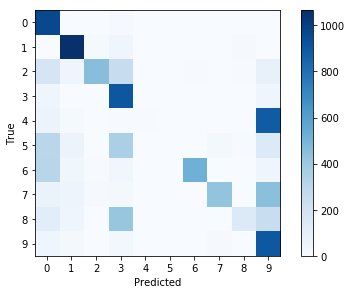

In [29]:
print_confusion_matrix()

In [30]:
# 绘制测试集中误分类的图像
def plot_example_errors():
    correct, cls_pred = session.run([corr_pred, y_pred_cls], feed_dict=feed_dict_test)
    incorrect = (correct == False)
    error_images = data.x_test[incorrect]
    true_labels = data.y_test_cls[incorrect]
    error_pred = cls_pred[incorrect]
    plot_images(error_images[0:9], cls_pred=error_pred[0:9], cls_true=true_labels[0:9])

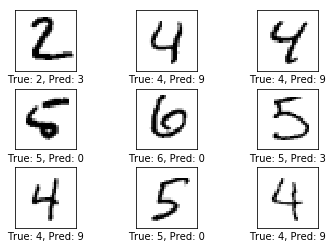

In [31]:
plot_example_errors()

In [36]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    for i, ax in enumerate(axes.flat):
        # weights shape [img_size_flat, 10]
        if i <10:
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel("Weights:{0}".format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

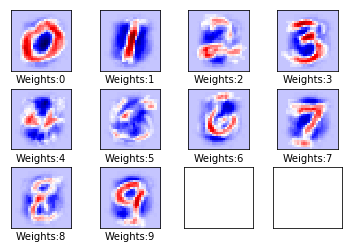

In [37]:
# 打印经过数轮迭代后的weights
plot_weights()

In [38]:
# 在进行10次优化
optimize(num_iterations=10)

In [39]:
print_accuracy()

Accuracy on test dataset:78.9%


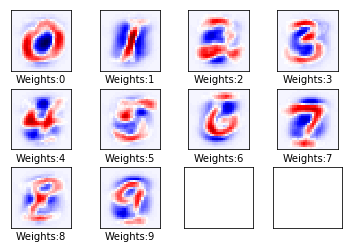

In [40]:
plot_weights()

In [41]:
# 在进行1000次优化
optimize(num_iterations=1000)

In [42]:
print_accuracy()

Accuracy on test dataset:90.9%


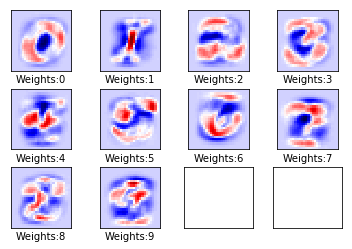

In [43]:
plot_weights()

In [44]:
# 关闭session 释放资源
session.close()